# Protein-Protein Interaction
This notebook describes the necessary steps for the protein-protein interaction network for all the genes in our reconstruction

In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import pickle
from google_sheet import GoogleSheet

# Data Fetching
import requests
import json
from pp_interactions import fetch_string_interactions, visualize_network

# Plotting
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
##### ----- Generate datasets from Google Sheet ----- #####

KEY_FILE_PATH = 'credentials.json'
SPREADSHEET_ID = '1L6qQQs48OdFd-mJcVqov_rSDoV90Ta0kib6UpL81OJQ'
gsheet_file = GoogleSheet(SPREADSHEET_ID, KEY_FILE_PATH)
sec_recon_sheet = 'SecRecon'
secrecon = gsheet_file.read_google_sheet(sec_recon_sheet)

In [3]:
# Load Reconstruction

gene_dict_path = 'gene_dict.pkl'
with open(gene_dict_path, 'rb') as file:
    gene_dict = pickle.load(file)

# Create gene_list
gene_list = list(gene_dict.keys())

### 1.STRINGS - Sec Recon

In [4]:
# Create the G graph object
G_string = fetch_string_interactions(gene_list)

# Draw the graph layout
pos = nx.spring_layout(G_string, seed=42, k=0.15, iterations=80)

# Add positions as node attributes
for node, (x, y) in pos.items():
    G_string.nodes[node]['x'] = x
    G_string.nodes[node]['y'] = y

# Save the network generated
nx.write_graphml(G_string, 'Network/string_interactions_sec_recon.graphml')

Fetching Interactions:   1%|▏                  | 9/1127 [00:06<13:36,  1.37it/s]


KeyboardInterrupt: 

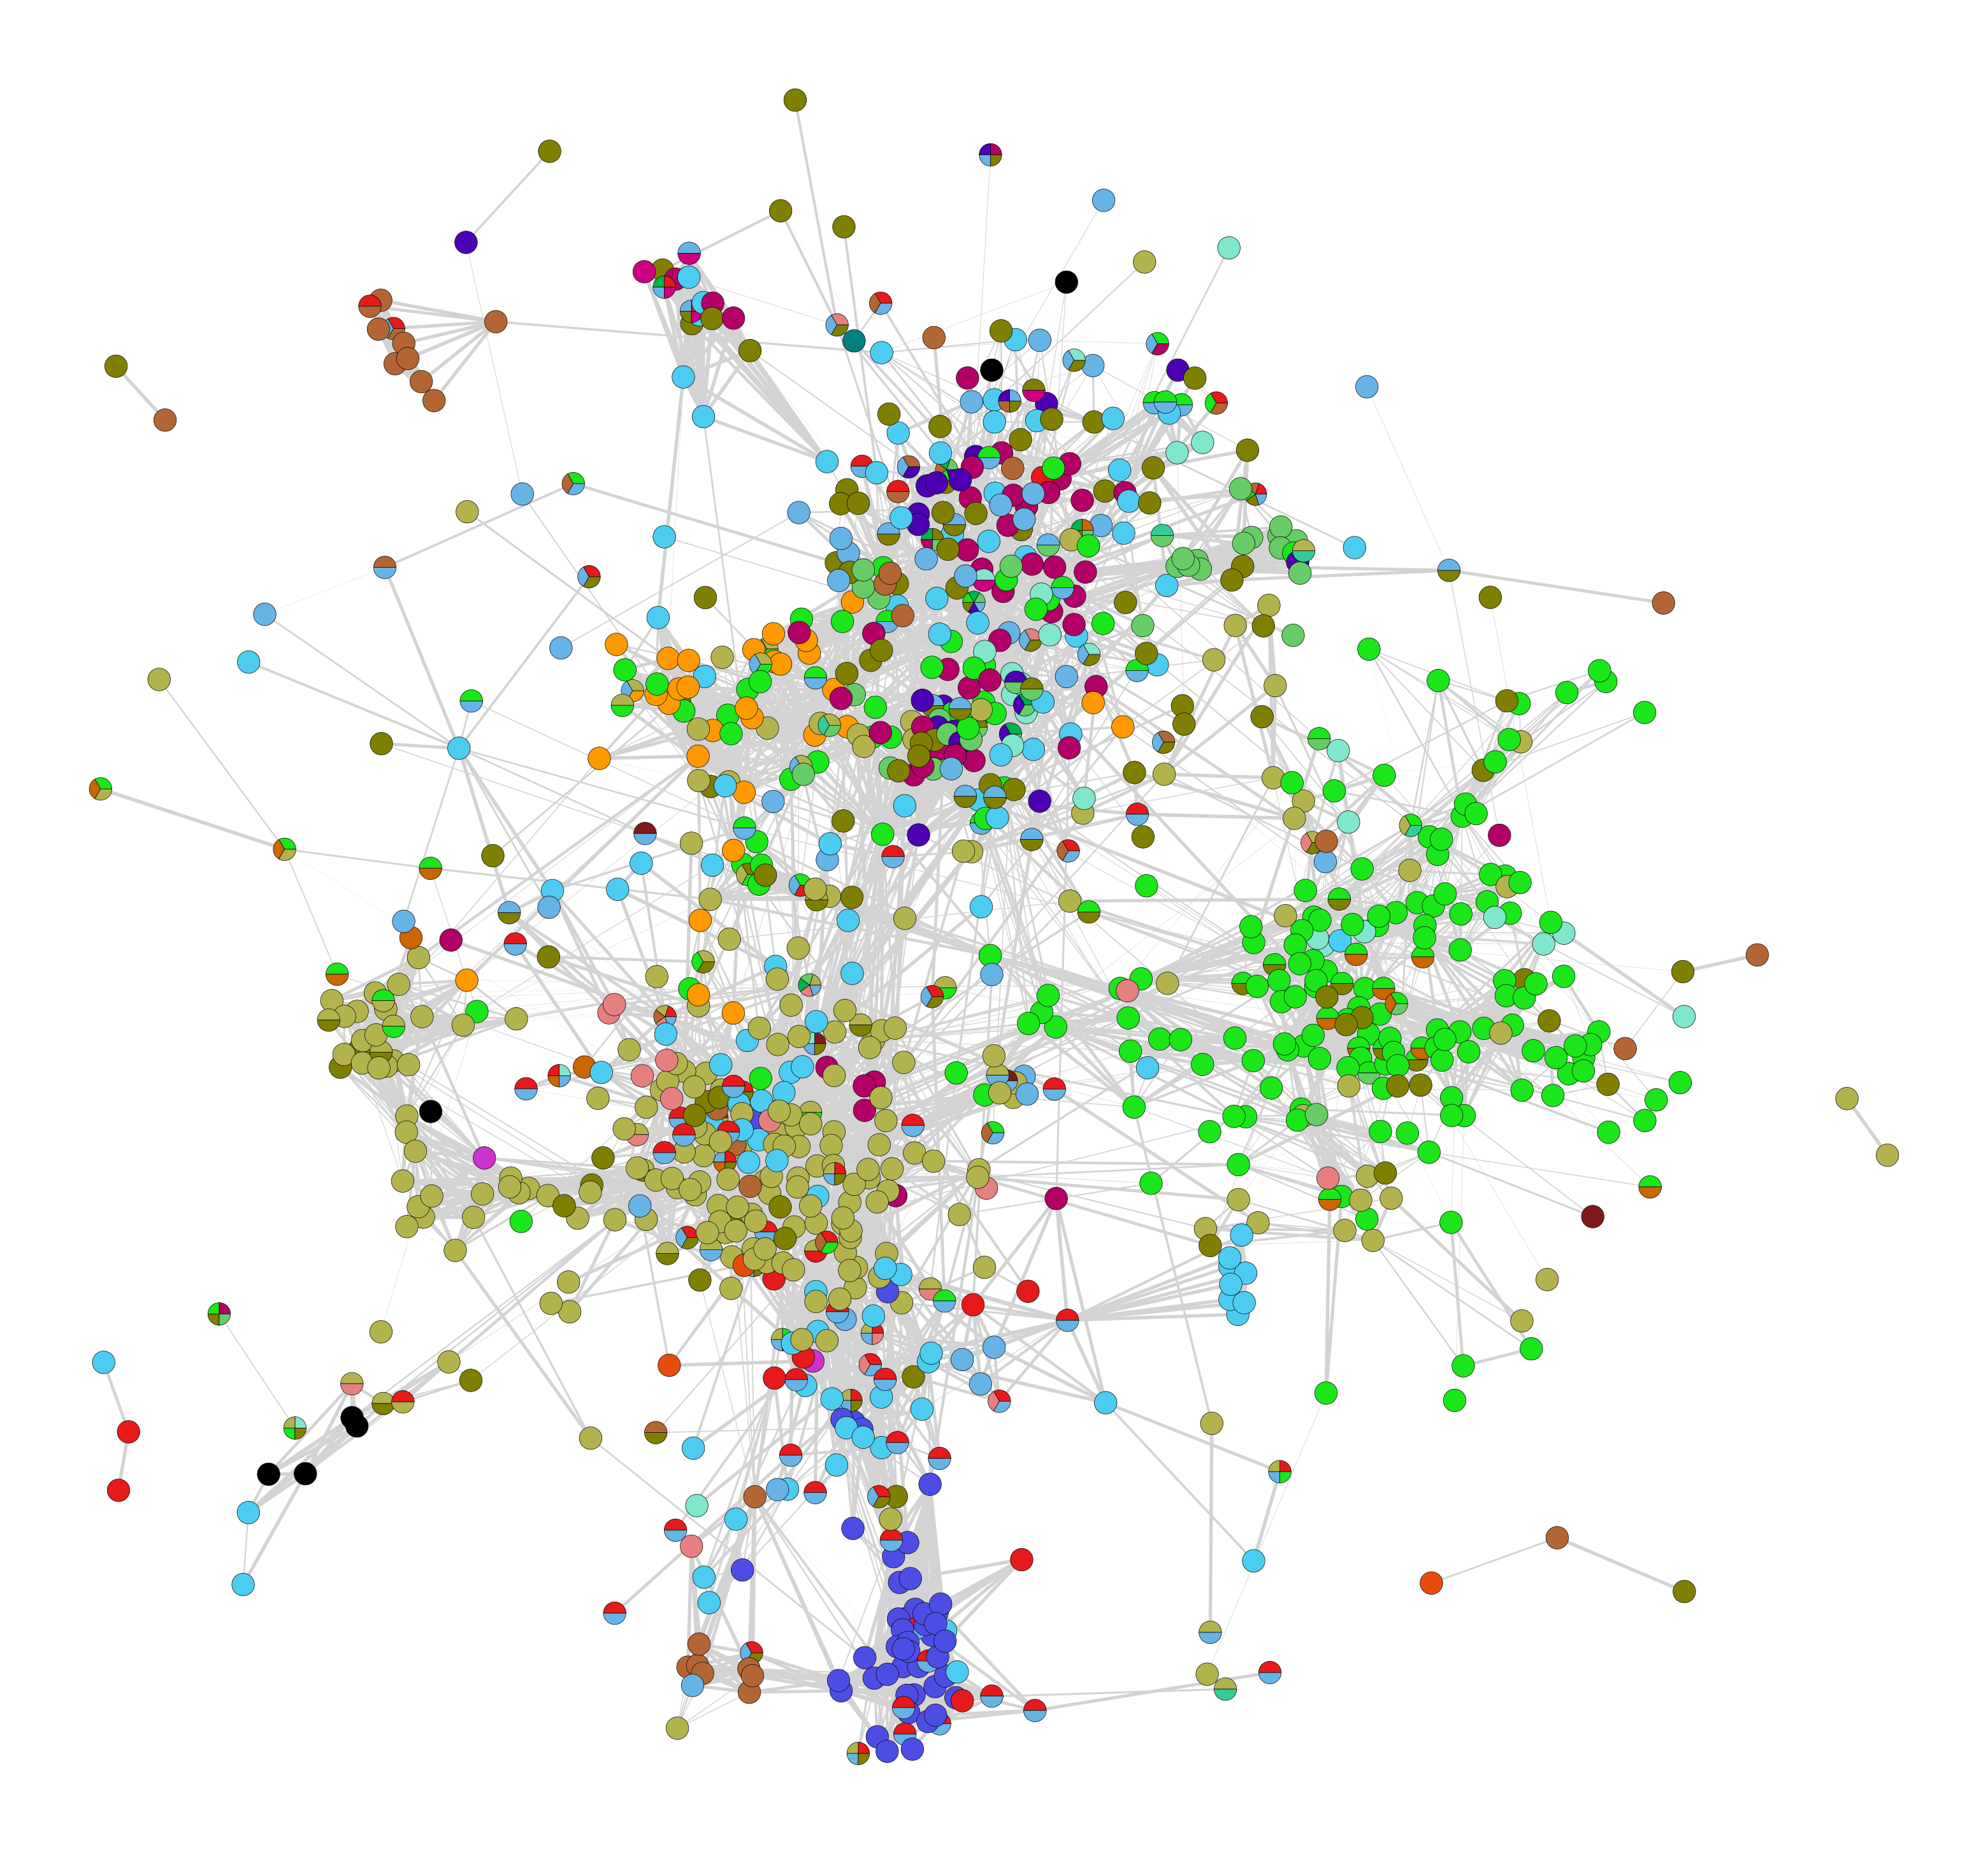

In [12]:
G_string = nx.read_graphml('Network/string_interactions_sec_recon.graphml')
# Extract positions from the graph
pos = {node: (float(data['x']), float(data['y'])) for node, data in G_string.nodes(data=True)}
#filename = f"Network/STRING_interactions_localizationcolor.png"

visualize_network(G_string, gene_dict, pos, node_size=0.012, color_by='localization', legends=False)

### 1.2 STRINGS - Sec Recon + Human Secretome

In [ ]:
# Load Human Secretome df
human_secretome = pd.read_excel('Input/human_secretome.xlsx')
# Subset of all the secreted proteins
human_secretome = human_secretome[human_secretome['Annotated category'].str.contains('secreted', case=False)]
human_secretome_list = list(human_secretome_dict.keys())

In [ ]:
# Creating the dictionary
human_secretome_dict = {row['Gene name']: {'systems': ['Secreted'], 'subcellular_localization': ['Secreted']} for index, row in human_secretome.iterrows()}

In [ ]:
# Merging human secretome dictionary with gene_dict
gene_sec_dict = gene_dict.copy()

for key, value in human_secretome_dict.items():
    if key not in gene_sec_dict:
        gene_sec_dict[key] = value

In [ ]:
G_string = fetch_string_interactions(gene_list, extra_genes=human_secretome_list)

# Save the network generated
nx.write_graphml(G_string, 'Network/string_interactions_sec_recon_plus_secretome.graphml')

In [ ]:
color_code = 'localization' #systems

#G_string = nx.read_graphml('Network/string_interactions_sec_recon_plus_secretome.graphml') # Uncoment if reading the G object
filename = f"Network/STRING_interactions_secrecon_secretome_{color_code}.png"
visualize_network(G=G_string, node_size=0.010, filename=filename, dist=0.15, color_by=color_code, gene_dict=gene_sec_dict, legends=True) 

### 1.3 STRINGS - Sec Recon divided by Systems + Human Secretome

In [ ]:
# Criteria for subsetting
criteria = [
    'Protein conformation',
    'Post-translational modifications',
    'Proteostasis',
    'Translocation',
    'Vesicle trafficking'
]

# Initialize empty dictionaries for each criteria
subset_dicts = {criterion: {} for criterion in criteria}

# Iterate through the original dictionary and apply the criteria
for protein, details in gene_sec_dict.items():
    for criterion in criteria:
        if criterion in details['systems'] or 'Secreted' in details['systems']:
            subset_dicts[criterion][protein] = details

In [ ]:
proteostasis = subset_dicts['Proteostasis']

In [ ]:
G_string = fetch_string_interactions(proteostasis)

# Save the network generated
#nx.write_graphml(G_string, 'Network/string_interactions_sec_recon_plus_secretome.graphml')

In [ ]:
color_code = 'localization' #systems

G_string = nx.read_graphml('Network/string_interactions_sec_recon_plus_secretome.graphml') # Uncoment if reading the G object
filename = f"Network/STRING_interactions_proteostasis_secretome_{color_code}.png"
visualize_network(G=G_string, node_size=0.012, filename=filename, dist=0.15, color_by=color_code, gene_dict=gene_sec_dict, legends=False) 

### 2.PrePPI
For this part, create a python dict with the uniprot IDs from secrecon as keys and the gene symbols as values, then mapped those gene symbols to the preppi database.

https://www.sciencedirect.com/science/article/pii/S0022283623001080?via%3Dihub
https://honiglab.c2b2.columbia.edu/PrePPI/

In [ ]:
# Initialize an empty dictionary to store the UniProt ID as key and the Gene Symbol as value
uniprot_gene_dict = {}

# Iterate through each row in the DataFrame
for index, row in secrecon.iterrows():
    # Check if the UniProt field is not None or NaN
    if pd.notna(row['HUMAN UNIPROT']):
        # Split the UniProt IDs by comma
        uniprot_ids = row['HUMAN UNIPROT'].split(',')
        # Map each UniProt ID to the gene symbol
        for uniprot_id in uniprot_ids:
            uniprot_gene_dict[uniprot_id.strip()] = row['GENE SYMBOL']

In [ ]:
preppi_file_path = 'Input/preppi_interactome/preppi.human_af.interactome.txt'
preppi_df = pd.read_csv(preppi_file_path, sep='\t')

In [ ]:
preppi_df

In [ ]:
# Map 'prot1' and 'prot2' using the dictionary
preppi_df['prot1_gene_symbol'] = preppi_df['prot1'].map(uniprot_gene_dict)
preppi_df['prot2_gene_symbol'] = preppi_df['prot2'].map(uniprot_gene_dict)

In [ ]:
filtered_df = preppi_df.dropna(subset=['prot1_gene_symbol', 'prot2_gene_symbol'])

In [ ]:
filtered_df = preppi_df.dropna(subset=['prot1_gene_symbol', 'prot2_gene_symbol'])

In [ ]:
filtered_df

In [ ]:
# Initialize an empty graph
G_preppi = nx.Graph()

seen_interactions = set()

for i,row in filtered_df.iterrows():
    protein1 = row['prot1_gene_symbol']
    protein2 = row['prot2_gene_symbol']
    interaction_tuple = (protein1, protein2)
    # Remove proteins interacting with themselves
    if protein1 != protein2:
        # Check if interaction is already seen, considering both directions
        if interaction_tuple not in seen_interactions and (protein2, protein1) not in seen_interactions:
            score = row['total_score']
            # Add nodes and edges to the graph if interaction is new
            G_preppi.add_node(protein1)
            G_preppi.add_node(protein2)
            G_preppi.add_edge(protein1, protein2, weight=score)
            # Add to seen interactions in both orders
            seen_interactions.add(interaction_tuple)
            seen_interactions.add((protein2, protein1))

In [ ]:


def visualize_network(G, main_genes=None, node_size=0.010, filename=None,dist=0.15, itrs=80, color_by='systems', gene_dict=dict, legends=True):
    """
    Visualize a protein-protein interaction network using matplotlib.
    
    Parameters:
    - G (networkx.Graph): The graph to visualize.
    - main_genes (list, optional): List of gene names for the title.
    - node_size (int, optional): Size of the nodes.
    - labels_size (int, optional): Font size for labels.
    - filename (str, optional): If provided, save the plot to this filename.
    """

    system_colors = {
    'Protein conformation': (1.0, 0.6, 0.0, 1.0),
    'Post-translational modifications': (0.1, 0.9, 0.1, 1.0), 
    'Proteostasis': (0.3, 0.3, 0.9, 1.0),
    'Translocation': (0.4, 0.7, 0.9, 1.0),
    'Vesicle trafficking': (0.7, 0.7, 0.3, 1.0),
    'Secreted': (0.9, 0.1, 0.1, 1.0)
    }
    # Scale edge widths
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    min_width = 0.1
    max_width = 1
    epsilon = 1e-10
    edge_weights = [min_width + (w - min(edge_weights)) * (max_width - min_width) / (max(edge_weights) - min(edge_weights) + epsilon) for w in edge_weights]
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(40, 40))
    
    # Draw the network
    pos = nx.spring_layout(G, seed=42, k=dist, iterations=itrs)
    
    
    # Draw edges with scaled widths
    nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color='lightgray', ax=ax)

    # Draw nodes as pie charts
    if color_by == 'systems':
        for node, (x, y) in pos.items():
            systems = gene_dict[node]['systems']
            colors = [system_colors[sys] for sys in systems]
            ax.pie([1]*len(systems), colors=colors, radius=node_size, center=(x, y), wedgeprops=dict(edgecolor='black', linewidth=0.5))

    elif color_by == 'localization':
        for node, (x, y) in pos.items():
            localizations = gene_dict[node]['subcellular_localization']
            colors = [localization_colors[loc] for loc in localizations]
            ax.pie([1]*len(localizations), colors=colors, radius=0.012, center=(x, y), wedgeprops=dict(edgecolor='black', linewidth=0.5))
    
    # Get the current axis limits
    x_values, y_values = zip(*pos.values())
    min_x, max_x = min(x_values), max(x_values)
    min_y, max_y = min(y_values), max(y_values)
    
    # Set new axis limits
    ax.set_xlim(min_x - 0.1, max_x + 0.1)
    ax.set_ylim(min_y - 0.1, max_y + 0.1)

    # Legend
    if legends:
        if color_by == 'systems':
            legend_patches = [mpatches.Patch(color=color, label=category) for category, color in system_colors.items()]
            plt.legend(handles=legend_patches, prop={'size': 25}, loc='lower left', bbox_to_anchor=(0.9, 0.6))
            plt.subplots_adjust(right=0.75)
        elif color_by == 'localization':
            legend_patches = [mpatches.Patch(color=color, label=category) for category, color in localization_colors.items()]
            plt.legend(handles=legend_patches, prop={'size': 20}, loc='lower left', bbox_to_anchor=(0.9, 0.6))
            plt.subplots_adjust(right=0.75)
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
         
    plt.show()

In [ ]:
filename = f"Network/PrePPI_interactions_localizationcolor.png"
visualize_network(G=G_preppi, node_size=0.012, filename=filename, dist=2, itrs=80, color_by='systems', gene_dict=gene_dict, legends=False) 

## 4. Uploading to NDEx

In [7]:
localization_colors = {
    'Actin Cytoskeleton': (0.7, 0.4, 0.2, 1.0),
    'Centrosome': (0.0, 0.5, 0.5, 1.0),
    'ERGIC': (1.0, 0.6, 0.0, 1.0),
    'Endosome': (0.0, 0.7, 0.3, 1.0), 
    'Recycling Endosome': (0.3, 0.0, 0.7, 1.0),
    'Late Endosome': (0.8, 0.0, 0.5, 1.0),
    'Early Endosome': (0.7, 0.0, 0.4, 1.0), 
    'Plasma Membrane': (0.5, 0.5, 0.0, 1.0), 
    'Golgi': (0.1, 0.9, 0.1, 1.0), 
    'cis-Golgi': (0.2, 0.8, 0.6, 1.0),
    'trans-Golgi': (0.4, 0.8, 0.4, 1.0), 
    'Nucleus': (0.9, 0.1, 0.1, 1.0),
    'Nucleolus': (0.5, 0.1, 0.1, 1.0),
    'Phagosome': (0.6, 0.3, 0.0, 1.0),
    'Proteasome': (0.3, 0.3, 0.9, 1.0),
    'Mitochondria': (0.9, 0.5, 0.5, 1.0),
    'Lysosome': (0.5, 0.9, 0.8, 1.0),  
    'Cytosol': (0.3, 0.8, 0.95, 1.0),
    'Cytoplasm': (0.4, 0.7, 0.9, 1.0),
    'Endoplasmic Reticulum': (0.7, 0.7, 0.3, 1.0),
    'Secreted': (0.8, 0.4, 0.0, 1.0),
    'Stress Granule': (0.9, 0.3, 0.05, 1.0),
    'Translation': (0.8, 0.2, 0.8, 1.0),
    'Unknown': (0.0, 0.0, 0.0, 1.0)
}

In [13]:
# Create a copy of the graph to preserve positions and colors
H = nx.Graph(G_string)

# Define a scaling factor
scaling_factor = 1500

# Convert localization color to hex string for Cytoscape
for node in H.nodes():
    localizations = gene_dict[node]['subcellular_localization']
    colors = [localization_colors[loc] for loc in localizations]

    # If there are multiple localizations, choose the first color for now
    if len(colors) == 1:
        hex_color = '#{:02x}{:02x}{:02x}'.format(
            int(colors[0][0] * 255), int(colors[0][1] * 255), int(colors[0][2] * 255))
        H.nodes[node]['color'] = hex_color
    else:
        # If multiple colors, you can pick the first
        hex_color = '#{:02x}{:02x}{:02x}'.format(
            int(colors[0][0] * 255), int(colors[0][1] * 255), int(colors[0][2] * 255))
        H.nodes[node]['color'] = hex_color

# Add positions to nodes
for node, (x, y) in pos.items():
    H.nodes[node]['x'] = x*scaling_factor  # Keep the position as floats for GraphML compatibility
    H.nodes[node]['y'] = y*scaling_factor
    
# Remove edges with weights below 1.0
#edges_to_remove = [(u, v) for u, v, data in H.edges(data=True) if data['weight'] < 1.0]
#H.remove_edges_from(edges_to_remove)

# Add metadata from the dictionary to the nodes
for gene, metadata in gene_dict.items():
    try:
        # For each gene, add the corresponding metadata as node attributes
        H.nodes[gene]['Systems'] = ', '.join(metadata['systems'])  # Join lists into comma-separated strings
        H.nodes[gene]['Subsystems'] = ', '.join(metadata['subsystems'])
        H.nodes[gene]['Processes'] = ', '.join(metadata['processes'])
        H.nodes[gene]['Subprocesses'] = ', '.join(metadata['subprocesses'])
        H.nodes[gene]['Subcellular_localization'] = ', '.join(metadata['subcellular_localization'])
        H.nodes[gene]['Protein_complexes'] = ', '.join(metadata['protein_complex'])
    except KeyError:
        print(f'Gene {gene} not present in PPI interaction map')

# Export the graph to GraphML format
nx.write_graphml(H, 'Network/string_interactions_sec_recon_cytoscape.graphml')

Gene AGAP2 not present in PPI interaction map
Gene ARAF not present in PPI interaction map
Gene ARHGAP1 not present in PPI interaction map
Gene ART1 not present in PPI interaction map
Gene AXL not present in PPI interaction map
Gene B3GNTL1 not present in PPI interaction map
Gene CSNK1A1L not present in PPI interaction map
Gene CTBP1 not present in PPI interaction map
Gene DNMBP not present in PPI interaction map
Gene DOCK5 not present in PPI interaction map
Gene GALNT20 not present in PPI interaction map
Gene GCNT7 not present in PPI interaction map
Gene GLT1D1 not present in PPI interaction map
Gene GLT6D1 not present in PPI interaction map
Gene GLT8D2 not present in PPI interaction map
Gene HAS1 not present in PPI interaction map
Gene HSP90AA4P not present in PPI interaction map
Gene HSP90AA5P not present in PPI interaction map
Gene HSP90AB2P not present in PPI interaction map
Gene HSP90AB3P not present in PPI interaction map
Gene HSP90AB4P not present in PPI interaction map
Gene KN